# LSTM et Attention


Dans ce notebook, le but sera de faire de la reconnaissance d'entités nommées en utilisant le modèle d'attention associé au LSTM.

L'attention est décrit dans l'article de [Vaswani et al., 2017](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf). 

Nous allons utiliser plusieurs couches d'attention à l'aide de la méthode de PyTorch `MultiheadAttention`.

In [1]:
!pip install torchtext==0.6.0
!pip install pytorch-crf

import time
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from torchcrf import CRF
from collections import Counter
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
from torchcrf import CRF
import numpy as np
import pandas as pd

import time
import random
import string
from itertools import chain

# Préparer les données


In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(lower = False) 
TAG = data.Field(unk_token = None) 

my_path = "data_ner/"
train_data, valid_data, test_data = data.TabularDataset.splits(
        path= my_path ,
        train="train.csv",
        validation="valid.csv",
        test="test.csv", format='csv', skip_header=True,
        fields=(("text", TEXT), ("tag", TAG))
    )

MIN_FREQ = 1

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ, # les mots qui apparaissent moins que MIN_FREQ fois seront ignorés du vocabulaire
                 vectors = "glove.6B.300d",
                 unk_init = torch.Tensor.normal_)

TAG.build_vocab(train_data)
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device, sort=False)

# padding index
TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

# Construire le modèle

On ajoute une nouvelle couche à notre modèle. On utilise le module de PyTorch `MultiheadAttention`, qui est une implémentation du mécanisme d'attention décrit dans [cet article](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf). 

Les inputs (*query*, *key*, et *value*) pour la couche d'attention sont les mêmes : la sortie du LSTM.

In [3]:
class BiLSTM(nn.Module):

    def __init__(self,
                 input_dim,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 lstm_layers,
                 attn_heads,
                 emb_dropout,
                 lstm_dropout,
                 attn_dropout,
                 fc_dropout,
                 word_pad_idx,  
                 tag_pad_idx):
        super().__init__()
        self.word_pad_idx = word_pad_idx  
        self.tag_pad_idx = tag_pad_idx  
        
        # LAYER 1A: Word Embedding
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=word_pad_idx
        )
        self.emb_dropout = nn.Dropout(emb_dropout)
        
        
        # LAYER 2: BiLSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0
        )
        
        # LAYER 3: Self-attention
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=attn_heads,
            dropout=attn_dropout
        )
        # LAYER 4: Fully-connected
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 
        # LAYER 5: CRF
        self.tag_pad_idx = tag_pad_idx
        self.crf = CRF(num_tags=output_dim)
        
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, tags=None):
        # words = [sentence length, batch size]
        # tags = [sentence length, batch size]
        
        # embedding_out = [sentence length, batch size, embedding dim]
        embedding_out = self.emb_dropout(self.embedding(words))
  
        # lstm_out = [sentence length, batch size, hidden dim * 2]
        lstm_out, _ = self.lstm(embedding_out)
        
        # crée mask pour padding
        # key_padding_mask = [batch size, sentence length]
        key_padding_mask = torch.as_tensor(words == self.word_pad_idx).permute(1, 0)
        # attn_out = [sentence length, batch size, hidden dim * 2]
        # attn_weight = [batch size, sentence length, sentence length]
        attn_out, attn_weight = self.attn(lstm_out, lstm_out, lstm_out, key_padding_mask=key_padding_mask)
        # fc_out = [sentence length, batch size, output dim]
        fc_out = self.fc(self.fc_dropout(attn_out))
        crf_mask = words != self.word_pad_idx
        crf_out = self.crf.decode(fc_out, mask=crf_mask)
        crf_loss = -self.crf(fc_out, tags=tags, mask=crf_mask) if tags is not None else None
        return crf_out, crf_loss, attn_weight

    def init_crf_transitions(self, tag_names, imp_value=-100):
        num_tags = len(tag_names)
        for i in range(num_tags):
            tag_name = tag_names[i]
            # I and <pad> impossible au début
            if tag_name[0] == "I" or tag_name == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
        # transition impossible O - I
        tag_is = {}
        for tag_position in ("B", "I", "O"):
            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        impossible_transitions_position = {
            "O": "I"

        }
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)
            
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                    
                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
        # transitions impossibles entre différents types
        impossible_transitions_tags = {
            "B": "I",
            "I": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [4]:
model = BiLSTM(
    input_dim=len(TEXT.vocab),
    embedding_dim=300,
    hidden_dim=64,
    output_dim=len(TAG.vocab),
    lstm_layers=2,
    attn_heads=16,
    emb_dropout=0.5,
    lstm_dropout=0.2,
    attn_dropout=0.2,
    fc_dropout=0.2,
    word_pad_idx=TEXT_PAD_IDX,
    tag_pad_idx=TAG_PAD_IDX
)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[TAG_PAD_IDX] = torch.zeros(300)

# CRF transitions initialisation
model.init_crf_transitions(
    tag_names=TAG.vocab.itos
)
print(f"Le modèle a {model.count_parameters():,} paramètres à entraîner.")


Le modèle a 7,441,978 paramètres à entraîner.


# Entraînement

 - Optimiseur et fonction loss

In [5]:
def optimiseur(model, lr=1e-5, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

optimizer = optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.01, second_weight_decay_rate=0.0)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

model = model.to(device)
criterion = criterion.to(device)

In [6]:
optimizer = optim.Adam(model.parameters(),  lr=1e-4)

 - Métriques

In [7]:
from sklearn.metrics import f1_score, classification_report

def f1_loss( preds, y, tag_pad_idx, full_report=False):
    index_o = TAG.vocab.stoi["O"]
    positive_labels = [i for i in range(len(TAG.vocab.itos))
                       if i not in (tag_pad_idx, index_o)]

    flatten_preds = [pred for sent_pred in preds for pred in sent_pred]

    positive_preds = [pred for pred in flatten_preds
                      if pred not in (tag_pad_idx, index_o)]

    flatten_y = [tag for sent_tag in y for tag in sent_tag]
    if full_report:
      
        positive_names = [TAG.vocab.itos[i]
                              for i in range(len(TAG.vocab.itos))
                              if i not in (tag_pad_idx, index_o)]
        print(classification_report(
                y_true=flatten_y,
                y_pred=flatten_preds,
                labels=positive_labels,
                target_names=positive_names
            ))

    return f1_score(
            y_true=flatten_y,
            y_pred=flatten_preds,
            labels=positive_labels,
            average="micro"
        ), flatten_preds, flatten_y

In [8]:
def train(model, iterator, optimizer, tag_pad_idx):
    
    epoch_loss = 0
    epoch_f1 = 0    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tag
      
        optimizer.zero_grad()

        pred_tags_list, batch_loss, _ = model(text, tags)
        
        # pour calculer la loss et le score f1, on flatten true tags
        true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
            ]
        f1,_,_ = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx)

        batch_loss.backward()
        
        optimizer.step()
        epoch_loss += batch_loss.item()
        epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator)

def evaluate(model, iterator, tag_pad_idx,full_report):
    
    epoch_loss = 0
    epoch_f1 = 0
    
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.tag
        
            pred_tags_list, batch_loss,_ = model(text, tags)
            true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
                ]
            
            f1, pred, lab = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx, full_report)
            preds.append(pred)
            labels.append(lab)
            epoch_loss += batch_loss.item()
            epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator),preds, labels

In [9]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 50

t_loss = []
t_f1 = []
v_loss = []
v_f1 = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
   
    
    train_loss, train_f1 = train(model, train_iterator, optimizer, TAG_PAD_IDX)
    t_loss.append(train_loss)
    t_f1.append(train_f1) 
    
    valid_loss, valid_f1,_,_ = evaluate(model, valid_iterator, TAG_PAD_IDX, full_report= False)
    v_loss.append(valid_loss)
    v_f1.append(valid_f1)
    
    #scheduler.step()
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model_conll.pt')
    

    if epoch%10 == 0: 
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 5s
	Train Loss: 661.254 | Train F1 score: 0.24%
	 Val. Loss: 560.469 |  Val. F1 score: 0.00%
Epoch: 11 | Epoch Time: 1m 5s
	Train Loss: 188.922 | Train F1 score: 52.35%
	 Val. Loss: 490.283 |  Val. F1 score: 43.81%
Epoch: 21 | Epoch Time: 0m 43s
	Train Loss: 143.336 | Train F1 score: 64.42%
	 Val. Loss: 513.242 |  Val. F1 score: 52.50%
Epoch: 31 | Epoch Time: 0m 38s
	Train Loss: 117.209 | Train F1 score: 71.57%
	 Val. Loss: 446.614 |  Val. F1 score: 61.12%
Epoch: 41 | Epoch Time: 0m 41s
	Train Loss: 98.804 | Train F1 score: 75.86%
	 Val. Loss: 458.566 |  Val. F1 score: 64.68%


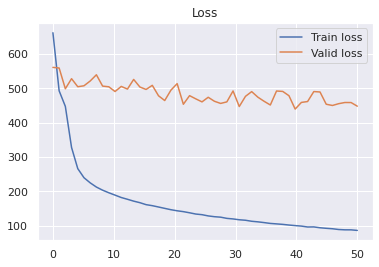

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_loss)
plt.plot(x,v_loss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

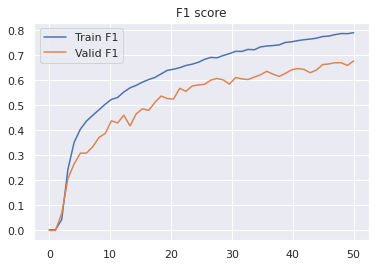

In [11]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_f1)
plt.plot(x,v_f1)
plt.title("F1 score")
plt.legend(["Train F1", "Valid F1"])

In [12]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
model.load_state_dict(torch.load('tut4-model_conll.pt'))

test_loss, test_f1, preds, labels = evaluate(model, test_iterator, TAG_PAD_IDX, full_report=False)
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

Test Loss: 568.749 |  Test F1 score: 54.10%


In [13]:
predict =  [item for sublist in preds for item in sublist]
true =  [item for sublist in labels for item in sublist]
confusion = confusion_matrix(true, predict)

### Matrice de confusion

In [14]:
confusion_df =pd.DataFrame(confusion)

confusion_df.columns=[i for i in TAG.vocab.itos][1:]
s = pd.Series([i for i in TAG.vocab.itos][1:])
confusion_df = confusion_df.set_index([s])

confusion_df['LOC'] = confusion_df['B-LOC'] + confusion_df['I-LOC']
confusion_df['PER'] = confusion_df['B-PER'] + confusion_df['I-PER']
confusion_df['ORG'] = confusion_df['B-ORG'] + confusion_df['I-ORG']
confusion_df['MISC'] = confusion_df['B-MISC'] + confusion_df['I-MISC']


confusion_df = confusion_df.drop(columns=[ i for i in TAG.vocab.itos if i != 'O' and i != '<pad>' ])

confusion_df.loc['LOC'] = confusion_df.loc['B-LOC'] + confusion_df.loc['I-LOC']
confusion_df.loc['PER'] = confusion_df.loc['B-PER'] + confusion_df.loc['I-PER']
confusion_df.loc['ORG'] = confusion_df.loc['B-ORG'] + confusion_df.loc['I-ORG']
confusion_df.loc['MISC'] = confusion_df.loc['B-MISC'] + confusion_df.loc['I-MISC']

confusion_df = confusion_df.drop([i for i in TAG.vocab.itos if i != 'O' and i != '<pad>' ])

confusion_df

,O,LOC,PER,ORG,MISC
O,38403,17,33,20,47
LOC,491,1256,98,52,27
PER,1886,12,851,17,6
ORG,1047,137,239,947,124
MISC,399,7,34,15,460


### Precision-Recall-F1Score

In [15]:
cm = confusion_df.to_numpy()

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

num_classes = 4
TN = []
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    
    temp = np.delete(temp, i, 1) 
    TN.append(sum(sum(temp)))
    
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

prf_df =pd.DataFrame()
prf_df['Precision'] = precision
prf_df['Recall'] = recall
prf_df['F1-score'] = f1

s = pd.Series([i for i in confusion_df.index])
prf_df = prf_df.set_index([s])

prf_df

,Precision,Recall,F1-score
O,0.909463,0.996963,0.951205
LOC,0.878936,0.652807,0.749180
PER,0.678088,0.306999,0.422647
ORG,0.901047,0.379711,0.534274
MISC,0.692771,0.502732,0.582647


On peut visualiser les poids d'attention.

In [16]:
def visualize_attn(tokens, weights):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(weights, cmap=plt.get_cmap("gray"))
    ax.set_xticks(list(range(len(tokens))))
    ax.set_yticks(list(range(len(tokens))))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    # Create colorbar
    _ = ax.figure.colorbar(im, ax=ax)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
                 rotation_mode="anchor")
    plt.tight_layout()
    plt.show()

def tag_sentence(model, device, sentence, text_field, tag_field):
 
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    max_word_len = max([len(token) for token in tokens])
    
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
    unk_idx = text_field.vocab.stoi[text_field.unk_token]  
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
    
    predictions,_, attn_weight = model(token_tensor)
    visualize_attn(tokens, attn_weight.detach().cpu().numpy()[0])
    
    predicted_tags = [tag_field.vocab.itos[t] for t in predictions[0]]
    
    return tokens, predicted_tags, unks

In [20]:
example_index = 3

sentence = vars(valid_data.examples[example_index])['text']
actual_tags = vars(valid_data.examples[example_index])['tag']

print("sentence : ", sentence)
print("actual tags : ", actual_tags)

sentence :  ['West', 'Indian', 'all-rounder', 'Phil', 'Simmons', 'took', 'four', 'for', '38', 'on', 'Friday', 'as', 'Leicestershire', 'beat', 'Somerset', 'by', 'an', 'innings', 'and', '39', 'runs', 'in', 'two', 'days', 'to', 'take', 'over', 'at', 'the', 'head', 'of', 'the', 'county', 'championship', '.']
actual tags :  ['B-MISC', 'I-MISC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


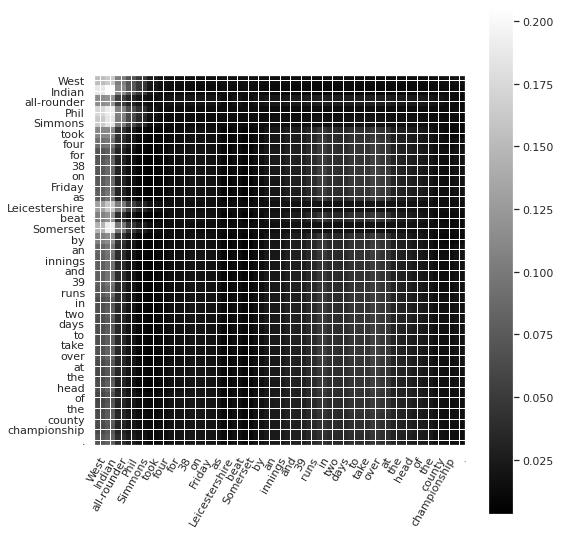

Pred. Tag				Actual Tag				Correct?				Token

B-MISC 				 B-MISC 				 ✔ 					 West
I-MISC 				 I-MISC 				 ✔ 					 Indian
O 					 O 					 ✔ 					 all-rounder
B-PER 				 B-PER 				 ✔ 					 Phil
I-PER 				 I-PER 				 ✔ 					 Simmons
O 					 O 					 ✔ 					 took
O 					 O 					 ✔ 					 four
O 					 O 					 ✔ 					 for
O 					 O 					 ✔ 					 38
O 					 O 					 ✔ 					 on
O 					 O 					 ✔ 					 Friday
O 					 O 					 ✔ 					 as
O 					 B-ORG 				 ✘ 					 Leicestershire
O 					 O 					 ✔ 					 beat
B-PER 				 B-ORG 				 ✘ 					 Somerset
O 					 O 					 ✔ 					 by
O 					 O 					 ✔ 					 an
O 					 O 					 ✔ 					 innings
O 					 O 					 ✔ 					 and
O 					 O 					 ✔ 					 39
O 					 O 					 ✔ 					 runs
O 					 O 					 ✔ 					 in
O 					 O 					 ✔ 					 two
O 					 O 					 ✔ 					 days
O 					 O 					 ✔ 					 to
O 					 O 					 ✔ 					 take
O 					 O 					 ✔ 					 over
O 					 O 					 ✔ 					 at
O 					 O 					 ✔ 					 the
O 					 O 					 ✔ 					 head
O 					 O 					 ✔ 					 of
O 					 O 	

In [21]:
tokens, pred_tags, unks = tag_sentence(model, 
                                       device, 
                                       sentence, 
                                       TEXT, 
                                       TAG)


print("Pred. Tag\t\t\t\tActual Tag\t\t\t\tCorrect?\t\t\t\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    space = 5 if pred_tag == 'O'else 4
    space1 = 5 if actual_tag == 'O'else 4    
    print(pred_tag,"\t"*space, actual_tag, "\t"*space1, correct,"\t"*5, token)

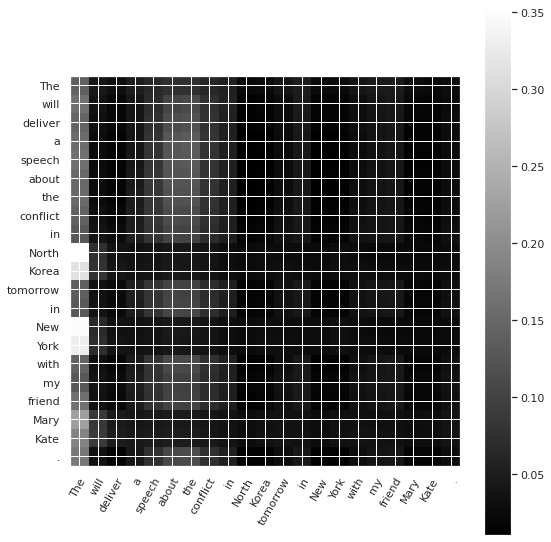

[]
Pred. Tag	Token

O		The
O		will
O		deliver
O		a
O		speech
O		about
O		the
O		conflict
O		in
B-LOC		North
I-LOC		Korea
O		tomorrow
O		in
B-LOC		New
I-LOC		York
O		with
O		my
O		friend
O		Mary
O		Kate
O		.


In [22]:
sentence = 'The will deliver a speech about the conflict in North Korea tomorrow in New York with my friend Mary Kate.'

tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence, 
                                  TEXT, 
                                  TAG)

print(unks)
print("Pred. Tag\tToken\n")


for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")